# Hawai'i

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cmocean
import ipywidgets as widgets
from IPython.display import display, IFrame, clear_output
from fatiando.gravmag import normal_gravity
# Load our custom helper functions from helpers.py
from helpers import plot_field, plot_hawaii_data, minmax

/home/leo/miniconda3/envs/case-studies-gravity/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/leo/miniconda3/envs/case-studies-gravity/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## The study region

The embeded Google Maps below show the region that we're going to study in this notebook. You can zoom and drag the map to get a feeling for the geographic location.

In [2]:
IFrame(width="100%", height="600px", 
       src="https://www.google.com/maps/embed?pb=!1m10!1m8!1m3!1d5916036.911229154!2d-157.7151201!3d20.5932929!3m2!1i1024!2i768!4f13.1!5e1!3m2!1sen!2sbr!4v1413401199263")

## Load the data

Our data is stored in the `data` folder as a netCDF file. See the notebook [`data/preparation.ipynb`](data/preparation.ipynb) for more information about how this file is generated.

In [3]:
data = xr.open_dataset('data/hawaii-gravity.nc')
data

<xarray.Dataset>
Dimensions:           (latitude: 301, longitude: 301)
Coordinates:
  * latitude          (latitude) float32 13.0 13.05 13.1 13.15 13.2 13.25 ...
  * longitude         (longitude) float32 -165.0 -164.95 -164.9 -164.85 ...
Data variables:
    gravity_earth     (latitude, longitude) float32 ...
    h_over_geoid      (latitude, longitude) float32 ...
    geoid             (latitude, longitude) float32 ...
    topography_grd    (latitude, longitude) float32 ...
    h_over_ellipsoid  (latitude, longitude) float32 ...
    topography_ell    (latitude, longitude) float32 ...

The grids that interest us are:

* `gravity_earth`: the raw gravity measured at the Earth's surface
* `h_over_ellipsoid`: the geometric (ellipsoidal) height of the gravity measurement
* `topography_ell`: the geometric height of the topography/bathymetry

Before looking at the gravity data, let's look at the observation height.

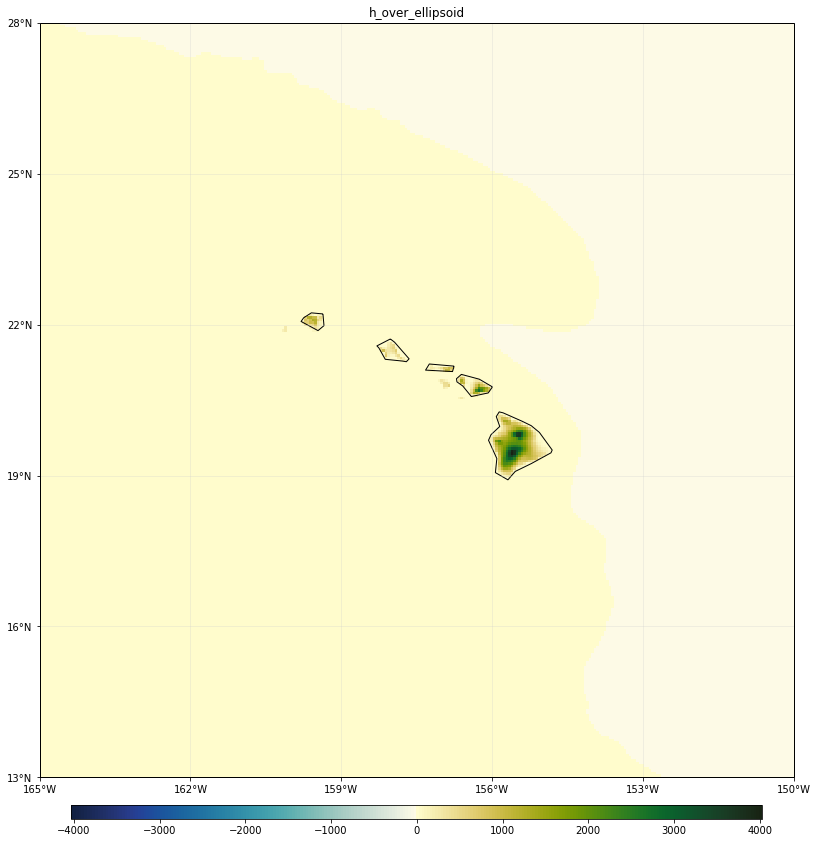

In [4]:
plot_hawaii_data(data, 'h_over_ellipsoid', cmap=cmocean.cm.delta)

## Normal Gravity

The first step is to compute the Normal Gravity $\gamma(lon, lat, height)$ at the same locations as our raw gravity grid. We calculate $\gamma$ using the closed-form equation in [Li and Götze (2001)](#1), so the free-air correction is not necessary.

In [5]:
data['normal_gravity'] = normal_gravity.gamma_closed_form(data.latitude, data.h_over_ellipsoid)

Compare the measured gravity with the theoretical Normal Gravity.

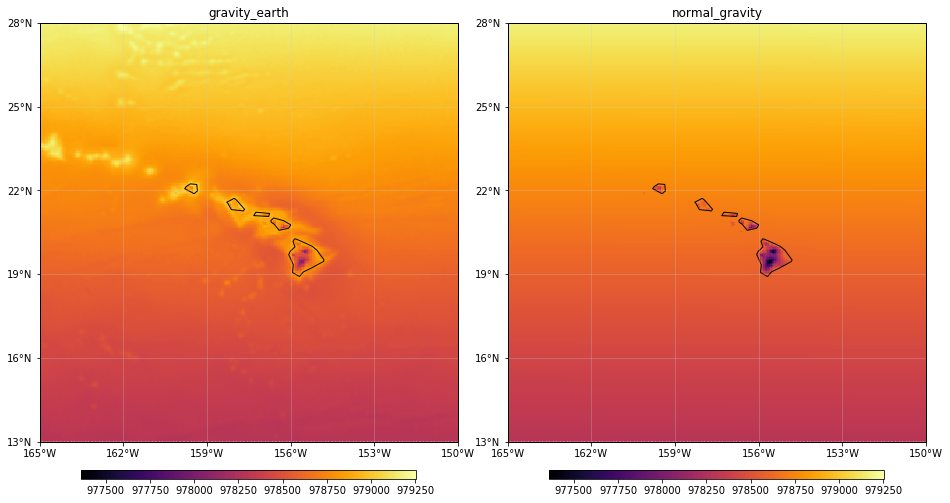

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(13, 8), 
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
fields = ['gravity_earth', 'normal_gravity']
cmaps = ['inferno', 'inferno']
kwargs = minmax(data, fields)
for field, ax, cmap in zip(fields, axes.ravel(), cmaps):
    plot_field(ax, data, field, cmap, cb_pad=0.05, cb_aspect=40, **kwargs)
plt.tight_layout(pad=0)

Remember that `gravity_earth` is measured at the Earth's surface.

### Talking points

* Why is the measured gravity lower on top of the islands?
* Does the reference model (i.e., the Normal Gravity) completely predict this effect?
* Why is gravity higher on top of the older islands and seamounts to the West?
* Why is gravity lower to the South of the region?

## Gravity Disturbance

We need to remove the Normal Earth effect in order to get to the underlying disturbances in the data due to the uneven density distribution of the Earth. The quantity we'll calculate is the *gravity disturbance*:

$$
\delta g(\lambda, \phi, h_{ell}) = g(\lambda, \phi, h_{ell}) - \gamma(\lambda, \phi, h_{ell})
$$

in which $\lambda$ is the longitude, $\phi$ is the latitude, and $h_{ell}$ is geometric height. 

Remember that $\gamma(\lambda, \phi, h_{ell})$ can be calculated directly using the formula of [Li and Götze (2001)](#1) or using the free-air approximation and Somigliana equation 

$$
\gamma(\lambda, \phi, h_{ell}) \approx \gamma(\lambda, \phi, h_{ell}=0) - 0.3086 h_{ell}
$$

Here, we'll calculate $\gamma(\lambda, \phi, h_{ell})$ directly.

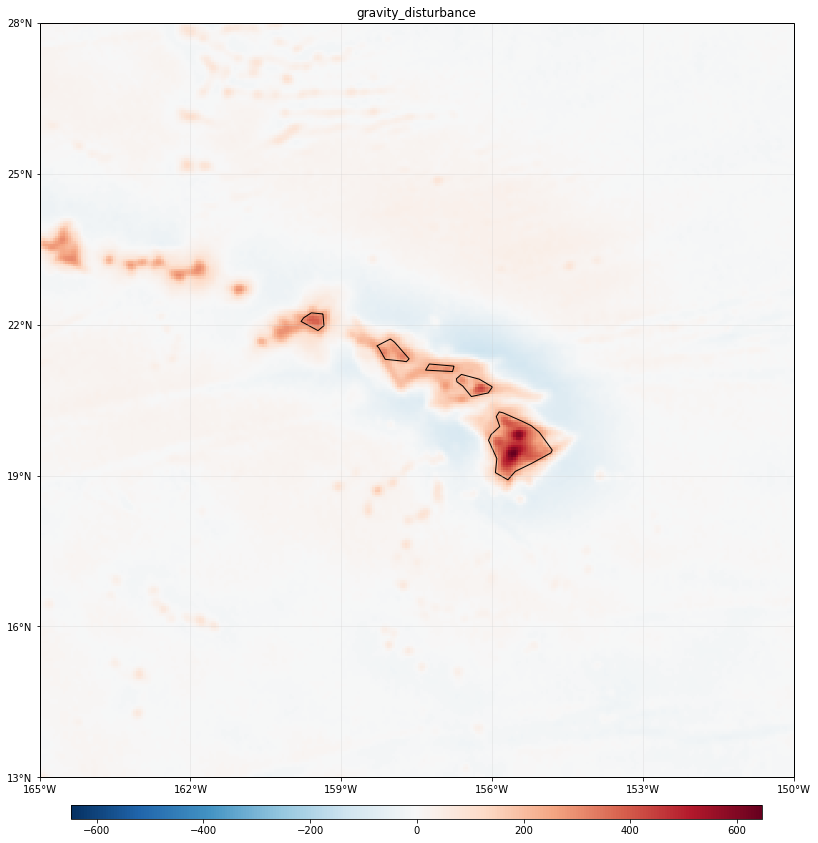

In [8]:
data['gravity_disturbance'] = data.gravity_earth - data.normal_gravity

plot_hawaii_data(data, 'gravity_disturbance', cmap='RdBu_r')

The positive peak over Hawai'i Island is dominating the map. Let's crop down the limits of the color bar so that we can see the other features. Use the slider to control the cutoff value for the colorbar to see what happens (only works when running the notebook live).

In [9]:
def crop_colorbar(cutoff):
    "Function to make the plot by croping the colorbar"
    vmin, vmax = -cutoff, cutoff
    plot_hawaii_data(data, 'gravity_disturbance', cmap='RdBu_r', vmin=vmin, vmax=vmax)
    
# Layout and show an interactive widget for controling the cutoff value for the colorbar 
title = widgets.HTML('<strong style="font-size: 1.5em;">Colorbar saturation</strong>')
label = widgets.Label("Absolute cutoff value (mGal)")
slider = widgets.FloatSlider(value=150, step=50, min=50, max=600, layout=widgets.Layout(width="500px"))
output = widgets.interactive_output(crop_colorbar, {'cutoff': slider})
display(widgets.VBox([title, widgets.HBox([label, slider]), output], 
                     layout=widgets.Layout(align_items="center")))

VkJveChjaGlsZHJlbj0oSFRNTCh2YWx1ZT11JzxzdHJvbmcgc3R5bGU9ImZvbnQtc2l6ZTogMS41ZW07Ij5Db2xvcmJhciBzYXR1cmF0aW9uPC9zdHJvbmc+JyksIEhCb3goY2hpbGRyZW49KEzigKY=


### Talking points

* bla

## Profiles

Let's look at profiles of this data and the topography to better understand what is going on.

In [57]:
class ProfileSelector(object):
    """
    Define a widget for selecting and plotting profiles from a dataset.
    
    Parameters
    ----------
    data : xarray.Dataset
        The data grid.
    fields : list of str
        The fields to plot in the upper profile
        
    """
    
    def __init__(self, data, fields, projection=ccrs.PlateCarree()):
        self.data = data
        self.fields = fields
        self._plot_initiated = False
        self.projection = projection

    def plot(self, location, dimension):
        
        if not self._plot_initiated:
          
            self.fig = plt.figure(figsize=(15, 9))
            grid = GridSpec(2, 3, hspace=0, wspace=0)
            self.ax_data = self.fig.add_subplot(grid[0,:-1])
            self.ax_topo = self.fig.add_subplot(grid[1,:-1])
            self.ax_data_map = self.fig.add_subplot(grid[0,-1], projection=self.projection)
            self.ax_topo_map = self.fig.add_subplot(grid[1,-1], projection=self.projection)
            
            self._topo_base = -10000
            
            ylim_topo = [self._topo_base, self.data.topography_ell.max()*1.1]
            ylim_data = list(sorted(minmax(self.data, self.fields).values()))

            self.ax_data.set_ylim(ylim_data)
            self.ax_data.set_ylabel('mGal')
            self.ax_topo.set_ylim(ylim_topo)
            self.ax_topo.set_ylabel('Tropography (m)')  
            self.ax_data.grid(True)
            
            self.ax_data.set_xticklabels([])

            self._data_lines = {}
            for field in self.fields:
                self._data_lines[field], = self.ax_data.plot([0], [0], '-', label=field)
            self.ax_data.legend(loc='upper right')

            self._water_fill = None
            self._topo_fill = None
            
            self.data[self.fields[0]].plot.pcolormesh(ax=self.ax_data_map, add_colorbar=False, cmap='RdBu_r')
            self.data['topography_ell'].plot.pcolormesh(ax=self.ax_topo_map, add_colorbar=False, cmap=cmocean.cm.delta)

            plt.tight_layout(pad=0, h_pad=0, w_pad=0)
            
            self._plot_initiated = True
        
        # Get the name of the other dimension
        dim_comp = set(self.data.dims).difference({dimension}).pop()

        x = self.data[dimension]
        xlim = [x.min(), x.max()]      
        profile = self.data.loc[{dim_comp: location}]
        
        for field in self.fields:
            self._data_lines[field].set_data(x, profile[field])
                    
        if self._topo_fill is not None:
            self._topo_fill.remove()
        if self._water_fill is not None:
            self._water_fill.remove()
        self._water_fill = self.ax_topo.fill_between(xlim, [0, 0], self._topo_base, color='#2780E3')
        self._topo_fill = self.ax_topo.fill_between(x, profile.topography_ell, self._topo_base, color='#333333')
        
        self.ax_data.set_xlim(xlim)
        self.ax_topo.set_xlim(xlim)
        self.ax_topo.set_xlabel(dimension.capitalize())
        plt.show()
    
    def interact(self):
        profile_interval = 10
        
        options = self.data.longitude.values.tolist()[::profile_interval]
        mid = options[len(options)//2]
        dimension = 'longitude'
        
        slider = widgets.SelectionSlider(options=options, value=mid, 
                                         layout=widgets.Layout(width="500px"))
        slider_label = widgets.Label("{} value".format(dimension.capitalize()))
        dimension_chooser = widgets.Dropdown(
            options=self.data.dims.keys(), value=data.dims.keys()[0], 
            description="Profile along")
                
        def displayer(location, dimension):
            self.plot(location, dimension)
            display(self.fig)
            
        def handle_dimension_change(change):
            dim_comp = set(self.data.dims).difference({change.new}).pop()
            slider_label.value = "{} value".format(dim_comp.capitalize())
            options = self.data[dim_comp].values.tolist()[::profile_interval]
            slider.options = options
            slider.value = options[len(options)//2]
            
        dimension_chooser.observe(handle_dimension_change, names='value')
            
        output = widgets.interactive_output(displayer, {'location': slider, 'dimension': dimension_chooser})
        layout = widgets.VBox([widgets.HBox([dimension_chooser, slider_label, slider]), output], 
                     layout=widgets.Layout(align_items="center"))
        
        # For some reason, calling _figure_setup inserts a plot in the output
        # Call clear_output to get rid of it.
        with output:
            clear_output(wait=True)
            display(self.fig)
        
        return layout

In [58]:
ProfileSelector(data, ['gravity_disturbance']).interact()

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdQcm9maWxlIGFsb25nJywgb3B0aW9ucz0odSdsYXRpdHVkZScsIHUnbG9uZ2l0dWRlJyksIHZhbHXigKY=


## Bouguer correction

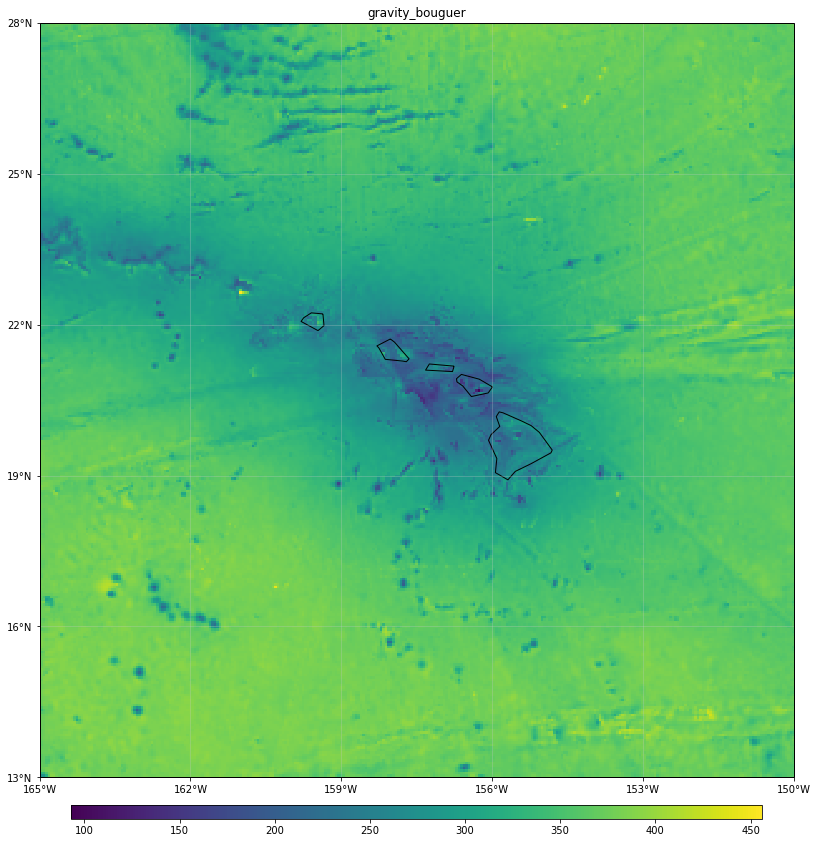

In [11]:
data['gravity_bouguer'] = data.gravity_disturbance - normal_gravity.bouguer_plate(data.topography_grd)

plot_hawaii_data(data, 'gravity_bouguer')

## Questions

* Why is the swell not present in the disturbance?
* Why is the Bouguer smaller over the islands?
* Why do some small trenches have big gravity lows (sediments)?

## References

<a id="1"></a>Li, X., and H. Götze (2001), Ellipsoid, geoid, gravity, geodesy, and geophysics, Geophysics, 66(6), 1660–1668, doi:[10.1190/1.1487109](https://doi.org/10.1190/1.1487109).